In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, \
    RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_pickle('./all_data.pkl')

In [3]:
NUM_LABEL_COLS = 13
NUM_COMPONENTS = 26
RANDOM_SEED = 0

In [4]:
df_filtered = df
df_filtered.shape

(9080, 10790)

In [5]:
# # exclude records we want to exclude
# df_filtered = df_filtered[df_filtered['trmp'] == '0']
# df_filtered = df_filtered[df_filtered['trmb'] == '0']
# df_filtered = df_filtered[df_filtered['otrb'] == '0']
# df_filtered = df_filtered[df_filtered['ext'] == '0']
# df_filtered = df_filtered[df_filtered['excl'] == '0']
# print('df filt shape: ', df_filtered.shape)

# # we are keeping sop, alt, tenr, tora, bari, clrt, other = 7
#                                                                         # off by one?
num_x_cols = df_filtered.shape[1] - NUM_LABEL_COLS                      # - 1 
# print('num_x_cols:', num_x_cols)

data = df.iloc[:, 1:num_x_cols].to_numpy() 
# ^ These are the features

scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [6]:
col_names = df.columns[-13:-2]

In [7]:
print(col_names)

Index(['sop', 'alto', 'tenr', 'tora', 'bari', 'clrt', 'othr', 'trmp', 'trmb',
       'otrb', 'ext'],
      dtype='object')


In [8]:
target = np.zeros(df.shape[0], int)

In [9]:
target.shape

(9080,)

In [10]:
indices = {}
targ_name = {}
k = 1
for instrument in col_names:
#     print(k)
    targ_col = df[[instrument]].to_numpy() # extract instrument target column
    ind = np.where(targ_col == '1')[0]     # find where instrument is playing
    indices[instrument] = ind              # write indices to dict
    target[ind] = k                        # put into a not-one-hot encoding
    k = k+1
    targ_name[k] = instrument
print(targ_name)

{2: 'sop', 3: 'alto', 4: 'tenr', 5: 'tora', 6: 'bari', 7: 'clrt', 8: 'othr', 9: 'trmp', 10: 'trmb', 11: 'otrb', 12: 'ext'}


In [11]:
print(target)

[3 3 3 ... 0 8 0]


In [12]:
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(data)
PCA(n_components=100)

PCA(n_components=100)

In [13]:
d = pca.transform(data)

In [14]:
x_train, x_test, y_train, y_test = \
     train_test_split(d, target, test_size=0.20, random_state=0)

In [15]:
def evaluate_classifer(clf, x_train, y_train, x_test, y_test):
    
    # train model
    clf_trained = clf.fit(x_train,y_train)

#     print(x_train.shape)
#     print(x_test.shape)
#     print(y_train.shape)
#     print(y_test.shape)
    
    # test model
    y_predict = clf.predict(x_test)
    # score model
    clf_score = clf.score(x_test, y_test)
    
    print(classification_report(y_test, y_predict))
    
    confus_mat = pd.DataFrame(confusion_matrix(y_test, y_predict))
    
    plt.imshow(confus_mat)
    
    return {'clf_trained': clf_trained,\
            'x_train': x_train, 'x_test': x_test,\
            'y_train': y_train, 'y_test': y_test,\
            'y_predict': y_predict,\
            'clf_score':clf_score,\
            'confus_mat':confus_mat}
    
def show_confus(eval_clf):
    plt.imshow(eval_clf['confus_mat'])
    plt.xlabel('predicted class')
    plt.ylabel('actual class')
    plt.title('confusion matrix')

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       593
           1       0.60      0.28      0.38        32
           2       0.73      0.24      0.36       170
           3       0.56      0.89      0.69       669
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        28
           7       1.00      0.12      0.22         8
           8       0.63      0.18      0.28       256
           9       1.00      0.16      0.28        37
          10       0.00      0.00      0.00         3
          11       0.83      0.33      0.48        15

    accuracy                           0.63      1816
   macro avg       0.55      0.27      0.31      1816
weighted avg       0.64      0.63      0.58      1816



D:\Program_Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


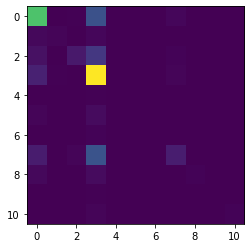

In [16]:
clf_SVM_poly = SVC(kernel = 'poly')
eval_SVM_poly = evaluate_classifer(clf_SVM_poly, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       593
           1       1.00      0.16      0.27        32
           2       0.62      0.35      0.45       170
           3       0.66      0.87      0.75       669
           4       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        28
           7       1.00      0.12      0.22         8
           8       0.61      0.30      0.41       256
           9       1.00      0.14      0.24        37
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00        15

    accuracy                           0.68      1816
   macro avg       0.51      0.25      0.28      1816
weighted avg       0.66      0.68      0.64      1816



D:\Program_Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


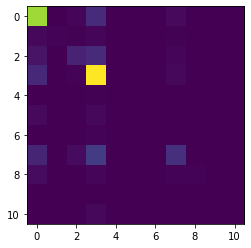

In [94]:
clf_SVM_rbf = SVC(kernel='rbf')
eval_SVM_rbf = evaluate_classifer(clf_SVM_rbf, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.60      0.80      0.69       593
           1       0.50      0.12      0.20        32
           2       0.46      0.25      0.33       170
           3       0.63      0.77      0.69       669
           4       0.00      0.00      0.00         5
           6       0.67      0.07      0.13        28
           7       0.00      0.00      0.00         8
           8       0.51      0.20      0.28       256
           9       1.00      0.19      0.32        37
          10       0.00      0.00      0.00         3
          11       1.00      0.13      0.24        15

    accuracy                           0.61      1816
   macro avg       0.49      0.23      0.26      1816
weighted avg       0.59      0.61      0.56      1816



D:\Program_Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


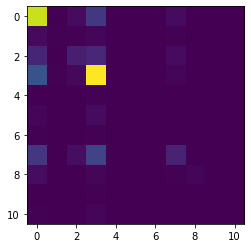

In [97]:
clf_forest_n10 = RandomForestClassifier(n_estimators=10)
eval_forest_n10 = evaluate_classifer(clf_forest_n10, x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       593
           1       1.00      0.25      0.40        32
           2       0.62      0.34      0.44       170
           3       0.67      0.87      0.76       669
           4       0.00      0.00      0.00         5
           6       1.00      0.07      0.13        28
           7       1.00      0.12      0.22         8
           8       0.66      0.32      0.44       256
           9       0.78      0.19      0.30        37
          10       0.00      0.00      0.00         3
          11       0.80      0.27      0.40        15

    accuracy                           0.69      1816
   macro avg       0.66      0.30      0.35      1816
weighted avg       0.69      0.69      0.65      1816



D:\Program_Files\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


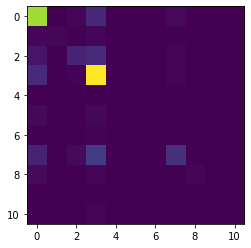

In [18]:
clf_bagged = BaggingClassifier(base_estimator=SVC(C=0.8622715404699739,
                                           probability=True),
                        n_estimators=500, 
                        max_features=21,
                        random_state=0,
                        n_jobs=-1)
eval_bagged = evaluate_classifer(clf_bagged, x_train, y_train, x_test, y_test)

In [25]:
eval_bagged.keys()
eval_bagged['confus_mat']

,0,1,2,3,4,5,6,7,8,9,10
0,501,0,10,67,0,0,0,14,1,0,0
1,8,8,3,10,0,0,0,3,0,0,0
2,32,0,58,71,0,0,0,9,0,0,0
3,71,0,6,581,0,0,0,9,1,0,1
4,1,0,0,4,0,0,0,0,0,0,0
5,13,0,0,12,0,2,0,1,0,0,0
6,1,0,1,5,0,0,1,0,0,0,0
7,59,0,14,100,0,0,0,83,0,0,0
8,15,0,1,10,0,0,0,4,7,0,0
9,0,0,1,2,0,0,0,0,0,0,0
